### Resnet 18

In [1]:
!ls data/hymenoptera_data/

train  val


In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
import time 
import os
import copy

import resnet_models

In [0]:
# Load Data
# Data Augemntation and Normalization for Training and Validation data
data_transforms = {
    "train": transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # imagenet_stats
    ]),
    "val": transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # imagenet_stats
    ])
    }

data_dir = 'data/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir,x), data_transforms[x])
                    for x in ['train', 'val']}

data_loaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, 
                                                num_workers=4) 
                                                for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [0]:
# Visualize a few images
def show_images(normalized_image_tensor, title=None):
    """ Imshow for Tensor """
    inp = normalized_image_tensor.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp  + mean
    inp = inp.clip(0,1)
    plt.imshow(inp)

    if title is not None:
        plt.title(title)
        
    plt.pause(0.001)  # pause a bit so that plots are updated


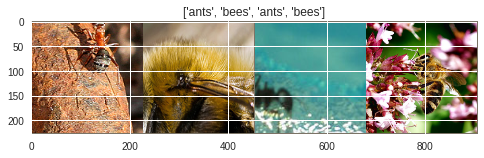

In [45]:
# get a batch of training data
inputs, classes = next(iter(data_loaders['train']))

# make grid of inputs
out = torchvision.utils.make_grid(inputs)
show_images(out, title=[class_names[x] for x in classes])

In [0]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    start_time = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch : {epoch+1}/{num_epochs}')
        print("-" * 2)

        for phase in ["train", "val"]:
            if phase == "train":
                scheduler.step()
                model.train() # set model to training mode
            else:
                model.eval() # set model to evaluate mode
            
            running_loss = 0
            running_corrects = 0 

            # Iterate over data
            for inputs, labels in data_loaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
            
                # zero the parameter gradients
                optimizer.zero_grad()

                # forward pass
                # track history if and only if train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    # backward + optimize only if in training phase
                    if phase=="train":
                        loss.backward()
                        optimizer.step()
                
                # statistics
                running_loss += loss.item()
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss /dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} loss: {epoch_loss:.4f}, acc: {epoch_acc:.4f}')

            # deep copy the model 
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    print()
    time_elapsed = time.time() - start_time
    print(f'training completed in {time_elapsed // 60}m {time_elapsed % 60}')
    print(f'Best validation accuracy: {best_acc:.4f}')

    # load best_model weights
    model.load_state_dict(best_model_wts)
    return model

In [0]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(data_loaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                show_images(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [0]:
# Finetuning the convnet
# Load a pretrained model and reset final fully connected layer.
model_ftn = resnet_models.resnet18(pretrained=True)
num_fltrs = model_ftn.fc.in_features
model_ftn.fc = nn.Linear(num_fltrs, 2)
model_ftn = model_ftn.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_ftn = optim.SGD(model_ftn.parameters(), lr=1e-3, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ftn, step_size=7, gamma=0.1)


In [50]:
# Train and evaluate
model_ftn = train_model(model_ftn, criterion, optimizer_ftn, exp_lr_scheduler, num_epochs=25)

Epoch : 1/25
--
train loss: 0.0111, acc: 0.5697
val loss: 0.0125, acc: 0.6797
Epoch : 2/25
--
train loss: 0.0094, acc: 0.7295
val loss: 0.0097, acc: 0.7908
Epoch : 3/25
--
train loss: 0.0075, acc: 0.8156
val loss: 0.0079, acc: 0.8758
Epoch : 4/25
--
train loss: 0.0062, acc: 0.8770
val loss: 0.0063, acc: 0.9020
Epoch : 5/25
--
train loss: 0.0049, acc: 0.9098
val loss: 0.0049, acc: 0.9150
Epoch : 6/25
--
train loss: 0.0044, acc: 0.9098
val loss: 0.0048, acc: 0.9281
Epoch : 7/25
--
train loss: 0.0036, acc: 0.9262
val loss: 0.0039, acc: 0.9346
Epoch : 8/25
--
train loss: 0.0033, acc: 0.9303
val loss: 0.0044, acc: 0.9281
Epoch : 9/25
--
train loss: 0.0033, acc: 0.9426
val loss: 0.0041, acc: 0.9281
Epoch : 10/25
--
train loss: 0.0033, acc: 0.9385
val loss: 0.0040, acc: 0.9281
Epoch : 11/25
--
train loss: 0.0034, acc: 0.9262
val loss: 0.0041, acc: 0.9281
Epoch : 12/25
--
train loss: 0.0034, acc: 0.9221
val loss: 0.0041, acc: 0.9281
Epoch : 13/25
--
train loss: 0.0031, acc: 0.9426
val loss: 0.

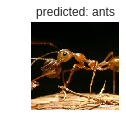

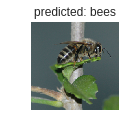

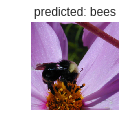

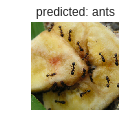

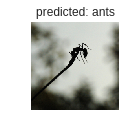

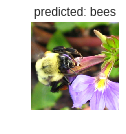

In [51]:
# Visualize the model
visualize_model(model_ftn)